![Image of Yaktocat](https://cdn.mos.cms.futurecdn.net/rLh7Dh7EKo8F6zmDtXYp8W.jpg)
# Table of Contents
1. [Introduction](#introduction)
2. [Install packages](#install-pkg)
3. [Data Dowloading](#data-download)
4. [Preprocessing](#preprocessing)<br>
    a. [Load and Clean Dataset](#load-and-clean)<br>
    b. [Data Analysis and Visualization](#data-ana-vis)
5. [Machine Learning Model](#ml-model)<br>
    a. [What and Why](#what-why)<br>
    b. [Training](#training)<br>
    c. [Result Anlysis and Demonstration](#result-ana-demon)
6. [Future Application](#future-app)
7. [Reference and External Link](#ref-and-extlink)

## 1. Introduction <a name="introduction"></a>
Have you dreamed about strolling around a dystopian metropole where violence, oppression, and cyberware implants aren't just common in 2077?
Have you dreamed about holding a Great Sword fight against a giant ancient dragon in Monster World?
Have you dreamed about driving Bugatti Veyron Super Sport in the city and all your opponents are in your rear mirror?
Playing video games seems to be a more and more popular entertainment options for people, especially in the middle of pandemic.
Gaming market values are almost double from 2012 to 2020. It's now a 150 billion industry with almost 10 thousands of game produced each year.
In this project, we are interested in what makes a game popular and how much revenue it may generate.

## 2. Install Packages <a name="install-pkg"></a>
```
pip install kaggle numpy matplotlib pandas sklearn
```
or use [environment.yml](https://github.com/syKevinPeng/game_sale_analysis/blob/main/environment.yml) to install packages in Conda environment
```
conda env update -f environment.yml
```
## 3. Data Downloading <a name="data-download"></a>

In [1]:
import kaggle
# remember to put kaggle.json to your C:/username/.kaggle
!kaggle datasets download -d ashaheedq/video-games-sales-2019

video-games-sales-2019.zip: Skipping, found more recently modified local copy (use --force to force download)


or directly download from kaggle webpage: [https://www.kaggle.com/ashaheedq/video-games-sales-2019](https://www.kaggle.com/ashaheedq/video-games-sales-2019)_
## 4. Preprocessing <a name="preprocessing"></a>
In this section, we will load and process the two datasets: "vgsales-12-4-2019.csv" is our main dataset and "video_games.csv"
is a complementary dataset we will use to fill in  important missing values like "Global_Sales" and "Critic_Score" in the first dataset.
**Datasets**

"vgsales-12-4-2019.csv" is a kaggle dataset with around 50000 records of game sales collected in 2019.
There are missing values in the column "Global_Sales", since this column is the predicted value for our model training,
we load another dataset "video_games.csv" to fill in these values as many as possible and drop the rest N/A values.

"video_games.csv" is a dataset of Steam game sales,
 we load it from [this repository](https://github.com/rfordatascience/tidytuesday/tree/master/data/2019/2019-07-30).
 It has a cloumn "owners" which includes a range of the number of players that own each game,
 we take the expected value (or median) of every range as the replacement for the missing data in the first dataset,
 and we will do the same for the missing values in "Critic_Score". To merge the two datasets after doing necessary
 processing, we will use a LEFT JOIN based on the columns "Name" and "Year".
### 4.a. Load and Clean Data <a name="load-and-clean"></a>
In the following cells we import the libraries,load the datasets using pandas.read_csv() function, and reate a preview of the datasets using df.head() function.

In [2]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
import locale

locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' )
df = pd.read_csv("vgsales-12-4-2019.csv")
additional = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2019/2019-07-30/video_games.csv")
df.head()

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,...,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.7,...,NaN,NaN,NaN,NaN,2006.0,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.0,...,NaN,NaN,NaN,NaN,1985.0,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.2,...,NaN,NaN,NaN,NaN,2008.0,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.7,/games/boxart/full_8932480AmericaFrontccc.jpg
3,4,PlayerUnknown's Battlegrounds,playerunknowns-battlegrounds,Shooter,NaN,PC,PUBG Corporation,PUBG Corporation,NaN,NaN,...,NaN,NaN,NaN,NaN,2017.0,13th Nov 18,http://www.vgchartz.com/game/215988/playerunkn...,1,NaN,/games/boxart/full_8052843AmericaFrontccc.jpg
4,5,Wii Sports Resort,wii-sports-resort,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,8.0,...,NaN,NaN,NaN,NaN,2009.0,NaN,http://www.vgchartz.com/game/24656/wii-sports-...,1,8.8,/games/boxart/full_7295041AmericaFrontccc.jpg


In [3]:
additional.head()

,number,game,release_date,price,owners,developer,publisher,average_playtime,median_playtime,metascore
0,1,Half-Life 2,"Nov 16, 2004",9.99,"10,000,000 .. 20,000,000",Valve,Valve,110.0,66.0,96.0
1,3,Counter-Strike: Source,"Nov 1, 2004",9.99,"10,000,000 .. 20,000,000",Valve,Valve,236.0,128.0,88.0
2,21,Counter-Strike: Condition Zero,"Mar 1, 2004",9.99,"10,000,000 .. 20,000,000",Valve,Valve,10.0,3.0,65.0
3,47,Half-Life 2: Deathmatch,"Nov 1, 2004",4.99,"5,000,000 .. 10,000,000",Valve,Valve,0.0,0.0,NaN
4,36,Half-Life: Source,"Jun 1, 2004",9.99,"2,000,000 .. 5,000,000",Valve,Valve,0.0,0.0,NaN


**Clean the additional dataset**

Let's process the additional dataset. First, we drop rows with NaN values in the columns "owners" and "release_date"
because we do not want to have missing values in these columns, and reset the index of the dataframe. Next, we divide
the values in the column "metascore" by 10 to make the unit (a float with one decimal place) match in both tables, and
store the results in a new column "Critic_Score". To calculate the median of the range of owners, we convert the values
in the column "owners" to string, then iterate through the dataframe to split the string and convert the results to integers,
finally we calculate the result (in millions). In the same loop, we also extract the value of year from the column "release_date".
 Note that there are NaN values in the column "Critic_Score" but we do not drop them because our main goal is to get more values
 for "Global_Sales". After renaming the columns that we will use to merge the datasets
 (by copying to new columns and dropping the original columns), we finish processing the additional dataset.

In [4]:
additional = additional.dropna(subset = ['owners', 'release_date'])
additional = additional.reset_index(drop = True)
additional['Critic_Score'] = additional['metascore']/10
additional['Year'] = additional['release_date']
additional['owners'] = additional['owners'].astype(str)
# calculate median of owners and extract value of year
for i in range(len(additional)):
    str(additional.loc[i, 'owners'])
    nums = additional.loc[i, 'owners'].split('\xa0..\xa0')
    additional.loc[i, 'owners'] = float((locale.atoi(nums[1]) - locale.atoi(nums[0])) / 2000000)
    temp = additional.loc[i, 'Year'].split(', ')
    if len(temp) != 2:
        additional.loc[i, 'Year'] = np.nan
    else:
        additional.loc[i, 'Year'] = int(temp[1])

additional = additional.dropna(subset = ['release_date'])
# drop useless columns and rename columns
additional = additional.drop(columns = ['number', 'price', 'average_playtime', 'median_playtime'])
additional['Name'] = additional['game']
additional['Developer'] = additional['developer']
additional['Global_Sales'] = additional['owners']
additional = additional.drop(columns=['metascore', 'release_date', 'publisher', 'game', 'developer', 'owners'])
additional.head()

,Critic_Score,Year,Name,Developer,Global_Sales
0,9.6,2004,Half-Life 2,Valve,5
1,8.8,2004,Counter-Strike: Source,Valve,5
2,6.5,2004,Counter-Strike: Condition Zero,Valve,5
3,NaN,2004,Half-Life 2: Deathmatch,Valve,2.5
4,NaN,2004,Half-Life: Source,Valve,1.5


**Merge the main dataset and the additional dataset**

Before merging the two datasets, we drop rows having missing values in the column "Year" as we will use this column
and the column "Name" in merging. Then we drop columns we will not use in data visualization and data analysis, which
are 'Rank', 'basename', 'Total_Shipped', 'Platform', 'Publisher', 'VGChartz_Score', 'Last_Update', 'url', 'status',
'Vgchartzscore', 'img_url', 'User_Score'.

The type of join we choose is left join, because we do not want to add excessive records from the additional dataset.

In [5]:
df = df.dropna(subset = ['Year'])
df['Year'] = df['Year'].astype(int)
df = df.drop(columns=['Rank', 'basename', 'Total_Shipped', 'Platform', 'Publisher', 'VGChartz_Score',
                      'Last_Update', 'url', 'status', 'Vgchartzscore', 'img_url',  'User_Score'])
# left join on 'Name', 'Year'
pd.merge(df, additional, on = ['Name', 'Year'] , how = 'left')
df.head()

,Name,Genre,ESRB_Rating,Developer,Critic_Score,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year
0,Wii Sports,Sports,E,Nintendo EAD,7.7,NaN,NaN,NaN,NaN,NaN,2006
1,Super Mario Bros.,Platform,NaN,Nintendo EAD,10.0,NaN,NaN,NaN,NaN,NaN,1985
2,Mario Kart Wii,Racing,E,Nintendo EAD,8.2,NaN,NaN,NaN,NaN,NaN,2008
3,PlayerUnknown's Battlegrounds,Shooter,NaN,PUBG Corporation,NaN,NaN,NaN,NaN,NaN,NaN,2017
4,Wii Sports Resort,Sports,E,Nintendo EAD,8.0,NaN,NaN,NaN,NaN,NaN,2009


**Process the merged dataset**

First we drop rows with missing values in the columns "Developer" and "Genre", and reset the index.
It is obvious to predict sales as numerical data but we have the accuracy concern(we will see accuracy in the **Result Analysis and Demonstration** section)
since the data may not demonstrate a strong linear trend. Therefore, we hope to predict it as categorical data: sale score is divided into 4 categories.
Games in ">10" category are expected to sell so greate that its name will left in history -- Grand Theft Auto, Pokemon, Call of duty and etc. You name it.
Games in "5-10" category are sold less than the top ones, but they are still great games. "5-1" games are good games. there are still large amount of customer want to
put them into their gaming library. The rest of games can be put into "1-0" categories. We respect the efforts that game developers put into them but they are relatively
niche.

For data analysis, we need to convert categorical variable to numerical variable. We choose to use label encoding on
the three categories, "Genre", "ESRB_Rating" and "Developer" because it is easier to process numerical values in data
analysis than processing string values. Since the total number of developers is large and we will use "Genre"
in data visualization, we will process "Developer" and "Genre" later. To create the dataframe for data analysis,
 we need to drop columns that we will not use, which are 'Name', 'PAL_Sales', 'JP_Sales', 'Other_Sales', 'Critic_Score'.
  Also, we will normalize the numerical values in the columns "Global_Sales" and "NA_Sales" by using the sklearn.preprocessing module.

In [6]:
df = df.dropna(subset=['Developer', 'Genre'])
df = df.reset_index(drop = True)
df['Sales_Ranking'] = df['Global_Sales']
# get values for the column 'Sales_Ranking'
for i in range(len(df)):
    df.loc[i, 'Developer'] = str(df.loc[i, 'Developer'])
    if df.loc[i, 'Sales_Ranking'] >= 10:
        df.loc[i, 'Sales_Ranking'] = 4
    elif df.loc[i, 'Sales_Ranking'] >= 5 and df.loc[i, 'Sales_Ranking'] < 10:
        df.loc[i, 'Sales_Ranking'] = 3
    elif df.loc[i, 'Sales_Ranking'] >= 1 and df.loc[i, 'Sales_Ranking'] < 5:
        df.loc[i, 'Sales_Ranking'] = 2
    else:
        df.loc[i, 'Sales_Ranking'] = 1

le = LabelEncoder()
# ohe = OneHotEncoder(handle_unknown = 'ignore')
df['Sales_Ranking'] = df['Sales_Ranking'].astype(int)
df = df.dropna(subset=['Global_Sales', 'ESRB_Rating'])
df['ESRB_Rating'] = le.fit_transform(df['ESRB_Rating'])
# df_temp = pd.DataFrame(ohe.fit_transform(df[['Genre']]).toarray())
# df = df.join(df_temp)

**Dataframe for data visualization**

Now we create the dataframe for data visualization. We drop rows with NaN values in the columns "Global_Sales"
and "NA_Sales" because these missing values can not be used in plotting the graphs.

In [7]:
df = df.reset_index(drop = True)
df = df[df['Global_Sales'] != 0.0]
df_for_visualization = df.dropna(subset = ['Global_Sales', 'NA_Sales'])
df_for_visualization = df_for_visualization.reset_index(drop = True)
df_for_visualization.head()

,Name,Genre,ESRB_Rating,Developer,Critic_Score,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Sales_Ranking
0,Grand Theft Auto V,Action,3,Rockstar North,9.4,20.32,6.37,9.85,0.99,3.12,2013,4
1,Grand Theft Auto V,Action,3,Rockstar North,9.7,19.39,6.06,9.71,0.60,3.02,2014,4
2,Grand Theft Auto: Vice City,Action,3,Rockstar North,9.6,16.15,8.41,5.49,0.47,1.78,2002,4
3,Grand Theft Auto V,Action,3,Rockstar North,NaN,15.86,9.06,5.33,0.06,1.42,2013,4
4,Call of Duty: Black Ops 3,Shooter,3,Treyarch,NaN,15.09,6.18,6.05,0.41,2.44,2015,4


**Dataframe for data analysis**

To create the dataframe for data analysis, we need to drop columns that we will not use,
which are 'Name', 'PAL_Sales', 'JP_Sales', 'Other_Sales', 'Critic_Score'. Also, we will normalize
the numerical values in the columns "Global_Sales" and "NA_Sales" by using the sklearn.preprocessing module.

In [8]:
df_for_training = df.drop(columns = ['Name', 'PAL_Sales', 'JP_Sales', 'Other_Sales', 'Critic_Score'])
df_for_training = df_for_training.dropna(subset = ['NA_Sales'])
temp_df = df_for_training.drop(columns=['Genre', 'ESRB_Rating', 'Developer', 'Year', 'Sales_Ranking'])
# create a temp dataframe for normalization of numerical values
x = temp_df.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
temp_df = pd.DataFrame(x_scaled)
# copy normalized values into the training dataframe
df_for_training['Global_Sales'] = temp_df[0]
df_for_training['NA_Sales'] = temp_df[1]
df_for_training = df_for_training.dropna(subset = ['Global_Sales', 'NA_Sales'])
df_for_training = df_for_training.reset_index(drop = True)
# apply label encoding on 'Genre' and 'Developer'
df_for_training['Genre'] = le.fit_transform(df_for_training['Genre'])
df_for_training['Developer'] = le.fit_transform(df_for_training['Developer'])
# Shuffle and reorder the dataframe
df_for_training = df_for_training.sample(frac=1)[['Genre','ESRB_Rating','Developer','NA_Sales','Year','Global_Sales','Sales_Ranking']]
df_for_training

,Genre,ESRB_Rating,Developer,NA_Sales,Year,Global_Sales,Sales_Ranking
3153,7,0,1772,0.017418,2007,0.024126,1
7407,17,0,937,0.010246,2002,0.005908,1
10654,15,0,695,0.002049,2002,0.000985,1
9829,0,3,1558,0.004098,2007,0.001969,1
7877,0,5,331,0.010246,2016,0.005416,1
...,...,...,...,...,...,...,...
3049,0,3,1412,0.009221,2005,0.025111,1
5429,7,3,1807,0.012295,2002,0.011324,1
7101,5,1,1271,0.013320,2007,0.006893,1
11286,7,2,125,0.001025,2005,0.000000,1


### 4.b Data Analysis and Visualization' <a name="data-ana-vis"></a>

## 5. Machine Learning Model <a name="ml-model"></a>
In this section, we are going to implement several models and predict global sales. In the world of machine learning, people
can split datas into two groups: numerical data and categorical data. Numerical data is everything that represented by numbers (integer
and floating point). It's continuous. Categorical data, however, is discrete. Different models will be used to predict these two type of data.

### 5.a What and Why <a name="what-why"></a>

We want to use *multiple linear regression* for predicting numerical sale number. The reason is that we intend to investigate
how strong the relationship is between many independent variables (in this case, critic score, developers and other variables) and
one dependent variable -- sale score. We made several assumptions for using multiple linear regression.
 - Homogeneity of Variance: the size of the error in our prediction doesn't change a lot
 - Independence of Observations: each game is independent of others.
 - Linearity: the line of best fit through the data point is a straight line.

Several models will be used for the prediction of categorical sale number: *Random forest*, *k-nearest neighbors* (KNN) and
*Support vector machine*(SVM)

Single decision tree suffers from a high variance, which makes them less accurate than other models. However, random forest fixes
this problem. Benefits of using random forests:
 -  Bagging and bootstrap reduce the output variance
 -  Able to handle large dataset with high dimensionality (which is our datset)

k-nearest neightbors, as one of the most famous classifications algorithm, surely have many positive sides:
 - No training period
 - Easily to add new data
 - Easy to implement

Here is the advantages of choosing support vector machine as one of our algorithem.
 -  Effective in high dimensional spaces
 -  Use a subset of training set in the decision function and, therefore, prevent overfitting
 -  Memory efficient

### 5.b Training <a name="training"></a>
**Multiple Linear Regression**

We will use sklearn library for most of our training task.

In [9]:
from sklearn import linear_model, model_selection
from sklearn.ensemble import RandomForestClassifier
import sklearn

# build model for numerical predictors
muti_linear_regression = linear_model.LinearRegression(n_jobs=-1)

Explanation:

This is a very simple and straight-forward model with n_jobs = -1, which means we want to use all available CPU cores for efficiency purpose

**Categorical Model**

In [10]:
# build model for categorical predictors
random_forest = RandomForestClassifier(n_estimators = 1000, random_state=42,max_depth=4,n_jobs = -1)
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)
svm = sklearn.svm.LinearSVC(max_iter=2000,dual=False)

Explanation:

To determine the number of trees (n_estimators in the function), we theoretically want as many trees as possible but the
margin of accuracy of getting more than 1000 trees become neglectable. random_state will increase the randomness when the algorithm is
bootstrapping.It is suggested that the maximum depth of the tree is sqrt(number of features), and also the
more depth of a tree, the better it perform with diminishing returns. I will just choose 4 and the benefit of more than 4 is too small. The number of jobs indicates how many
threads that are working in parallel.

As for kNN, to determine the number of neighbors, I did several experiments. It turns out that n_neightbors = 5 can generate best output. Too small n_neightbor will result in
unstable decision boundaries will too large will make the decision boundaries unclear.

SVM is little bit intriguing. There are two options for us to set the "decision_function_shape". One is "ovo", which stands for one-verses-one, and the other option is called one-vs-the-rest.
One-verse-one compare each classcifier with the predict value one by one while the one verse the rest option treats the x as a group and compare it with the y. In our case, we consider all the regressor
as a group. The reason why we set max_iter to 2000 is that it will not converge at default number of iterations

In [11]:
# Assign first several columns as X and last two columns as ground truth
X = df_for_training.iloc[:, 0:5]
y_categorical = df_for_training[['Sales_Ranking']].to_numpy().flatten()
y_numerical = df_for_training[['Global_Sales']].to_numpy().flatten()

In [12]:
# numerical model
# 10-fold cross validation for multi-linear regression:
linear_score = []
X = X.to_numpy()
for train_index, test_index in model_selection.KFold(n_splits=10).split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_numerical[train_index], y_numerical[test_index]
    model = muti_linear_regression.fit(X_train,y_train)
    score = model.score(X_test,y_test)
    linear_score.append(score)
print('The average score for linear regression is ',np.average(linear_score))
print("The standard error of the score is ", np.std(linear_score))

The average score for linear regression is  0.8329380526739645
The standard error of the score is  0.044375140974953854


In [13]:
# categorical model
# Implement 10-fold cross validation
rfr_score = model_selection.cross_val_score(random_forest, X, y_categorical, cv = 10)
print("The average score for Random Forest is ", np.average(rfr_score))
print("The standard error of the score is ", np.std(rfr_score))
knn_score = model_selection.cross_val_score(knn, X, y_categorical, cv = 10)
print("The average score for kNN is ", np.average(knn_score))
print("The standard error of the score is ", np.std(knn_score))
svm_score = model_selection.cross_val_score(svm,X, y_categorical, cv = 10)
print("The average score for SVM is ", np.average(svm_score))
print("The standard error of the score is ", np.std(svm_score))

The average score for Random Forest is  0.9443951860398265
The standard error of the score is  0.006578077092256287
The average score for kNN is  0.8731059988035025
The standard error of the score is  0.005475860780734276
The average score for SVM is  0.8992760413024732
The standard error of the score is  0.01149247828173759


### 5.c Result Anlysis and Demonstration <a name="result-and-demon"></a>
Below is the bar graph of accuracy score for different models.

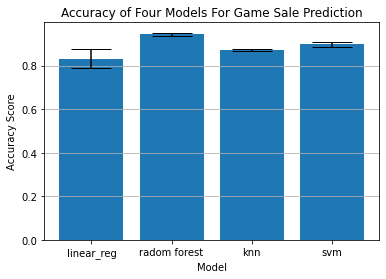

In [14]:
import matplotlib.pyplot as plt
models = ['linear_reg', 'radom forest', 'knn', 'svm']
scores = [linear_score,rfr_score, knn_score,svm_score]
accuracy = np.average(scores,axis=1)
std = np.std(scores,axis=1)
fig, ax = plt.subplots()
ax.bar(models,accuracy,align = 'center',yerr = std, capsize=20)
ax.set_xticks(models)
ax.set_title('Accuracy of Four Models For Game Sale Prediction')
ax.yaxis.grid(True)
ax.set_xlabel("Model")
ax.set_ylabel('Accuracy Score')
plt.show()

Random forest model has the best accuracy score and I think bagging and bootstrap could be the reason why it outperformed other models.
Also, the prediction for categorical variable generally better than the numerical prediction becuase, intuitively, predicting a category is
easier than a specific number.

Since we are interested in the difference between two variables for the same subject, we are going to perform paired-t test for the predicted value and the ground truth to see
the statistical difference between them. Our null hypothesis would be the average difference between the predicted value and ground truth is 0 and alternative hypothesis is the
average difference is not 0. We choose alpha value = 0.05

In [15]:
from scipy import stats
muti_linear_regression.fit(X,y_categorical)
pred_y = muti_linear_regression.predict(X)
(statistics, pvalue) = stats.ttest_rel(y_categorical, pred_y)
print("paired t-test for  multi-linear regression has the following result")
print(f'test statistics = {np.round(statistics,3)} \np value = {np.round(pvalue,3)}')

paired t-test for  multi-linear regression has the following result
test statistics = 0.0 
p value = 1.0


In [16]:
random_forest.fit(X,y_categorical)
pred_y = random_forest.predict(X)
(statistics, pvalue) = stats.ttest_rel(y_categorical, pred_y)
print("paired t-test for random forest  has the following result")
print(f'test statistics = {np.round(statistics,3)} \np value = {np.round(pvalue,3)}')

paired t-test for random forest  has the following result
test statistics = 7.85 
p value = 0.0


In [17]:
knn.fit(X,y_categorical)
pred_y = knn.predict(X)
(statistics, pvalue) = stats.ttest_rel(y_categorical, pred_y)
print("paired t-test for k-nearest neightbor has the following result")
print(f'test statistics = {np.round(statistics,3)} \np value = {np.round(pvalue,3)}')

paired t-test for k-nearest neightbor has the following result
test statistics = 22.912 
p value = 0.0


In [18]:
svm.fit(X,y_categorical)
pred_y = svm.predict(X)
(statistics, pvalue) = stats.ttest_rel(y_categorical, pred_y)
print("paired t-test for support vector machine has the following result")
print(f'test statistics = {np.round(statistics,3)} \np value = {np.round(pvalue,3)}')

paired t-test for support vector machine has the following result
test statistics = 39.691 
p value = 0.0


From above result, it is interesting to see that we failed reject null hypothesis (i.e. there is no difference between
the predicted value and ground truth for multi-linear regression paired-t test) but reject the null hypothesis (that is, there IS a difference)
for the rest of three paired-t test. However, according to the accuracy score, random forest model achieved the highest. Why does this happen?

According the formula that calculate t-value, we need to find the standard deviation of the difference between two groups. This standard deviation doesn't
make sense when it comes to category. You can think it as using l2 loss (mean squared error) instead of cross-entropy loss for categorical problem. Therefore,
we'd better directly use accuracy score for model-model comparison.

## 6. Future Application <a name="future-app"></a>

## 7. Reference and External Link <a name="ref-and-extlink"></a>
#### Gaming industry statistics
 - https://www.statista.com/statistics/292056/video-game-market-value-worldwide/
 - https://www.statista.com/statistics/552623/number-games-released-steam/

#### Want to to know more about multiple linear regression?
 - https://www.scribbr.com/statistics/multiple-linear-regression/
 - https://en.wikipedia.org/wiki/Linear_regression
 - https://towardsdatascience.com/understanding-multiple-regression-249b16bde83e

#### Extend materials for support vector machine, Knn, random forest
 - https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47
 - https://www.youtube.com/watch?v=1NxnPkZM9bc
 - https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761
 - https://scikit-learn.org/stable/modules/svm.html
 - https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
 - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

#### paired-t test reading:
 - https://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/SAS/SAS4-OneSampleTtest/SAS4-OneSampleTtest7.html